In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import *
from keras.models import Sequential
from keras.layers import *
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam

In [96]:
os.chdir('C:\\Users\\Hp\\OneDrive\\Documents\\GitHub\\Thoucentric\\DataSets')

In [97]:
cr_1=pd.read_csv('crude_close.csv')
cr_2=pd.read_csv('crude_open.csv')
cr_3=pd.read_csv('crude_low.csv')
cr_4=pd.read_csv('crude_high.csv')
cr_merged_1 = pd.merge(cr_1, cr_2, on='date')
cr_merged_2 = pd.merge(cr_merged_1, cr_3, on='date')
cr = pd.merge(cr_merged_2, cr_4, on='date')

Merge function combines dataframes with a parameter 'on' which defines the basis for the merge. Here we are merging on the basis of date which means that the final dataframe would have all rows having common dates. There are multiple ways of merging but the default is intersection of the dataframes.

In [98]:
df=pd.read_csv('Iceus_sugar_all.csv')
df=pd.merge(df, cr, on='date')
df.head() 

,date,low,high,close,open,cr_close,cr_open,cr_low,cr_high
0,2017-01-03T00:00:00.000Z,19.58,20.55,20.51,19.63,56.46,57.05,55.30,58.37
1,2017-01-04T00:00:00.000Z,20.41,20.94,20.89,20.55,56.89,55.73,55.33,56.55
2,2017-01-05T00:00:00.000Z,20.66,21.18,20.78,20.89,57.10,56.35,56.01,57.35
3,2017-01-06T00:00:00.000Z,20.30,20.84,20.75,20.66,57.10,56.88,56.28,57.47
4,2017-01-09T00:00:00.000Z,20.36,20.75,20.42,20.74,53.64,56.81,54.74,57.00


Set date to date format form a string format


In [99]:
train_dates=pd.to_datetime(df['date'])

Take all columns except date as X features 

In [100]:
X=df.iloc[:, 1:8]

In [101]:
scaler=StandardScaler()
X=scaler.fit_transform(X)

We set how many days of prediction we do while taking into account how many past days. Here, we calculate any 1 day from previous 14 days of data

In [102]:
train_X=[]
train_y=[]
n_future=1
n_past=14
for i in range(n_past, len(X) - n_future + 1):
    train_X.append(X[i-n_past:i, 0:X.shape[1]])         #understand this exactly
    train_y.append(X[i+n_future-1:i+n_future, 0])       #undersatnd this exactly
X1, y1 = np.array(train_X), np.array(train_y)
X1.shape, y1.shape

((1768, 14, 7), (1768, 1))

In [103]:
X_train, y_train = X1[:1500], y1[:1500]
X_test, y_test = X1[1500:], y1[1500:]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1500, 14, 7), (1500, 1), (268, 14, 7), (268, 1))

When setting up the LSTM model, when we use multiple LSTM layers, we use another parameter 'return_sequences' which tells the model to return the output of the first LSTM layer to the next layer as input in the form of a sequence as LSTM requices sequential data. 

In [104]:
model=Sequential()
model.add(LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1]))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 14, 64)            18432     
                                                                 
 lstm_9 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 30,881
Trainable params: 30,881
Non-trainable params: 0
_________________________________________________________________


In [105]:
history=model.fit(X_train, y_train, epochs=40, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/40
85/85 [==============================] - 3s 13ms/step - loss: 0.1313 - val_loss: 0.0636
Epoch 2/40
85/85 [==============================] - 1s 8ms/step - loss: 0.0381 - val_loss: 0.3662
Epoch 3/40
85/85 [==============================] - 1s 7ms/step - loss: 0.0341 - val_loss: 0.0307
Epoch 4/40
85/85 [==============================] - 1s 7ms/step - loss: 0.0319 - val_loss: 0.0309
Epoch 5/40
85/85 [==============================] - 1s 7ms/step - loss: 0.0305 - val_loss: 0.0529
Epoch 6/40
85/85 [==============================] - 1s 7ms/step - loss: 0.0277 - val_loss: 0.1005
Epoch 7/40
85/85 [==============================] - 1s 7ms/step - loss: 0.0296 - val_loss: 0.0365
Epoch 8/40
85/85 [==============================] - 1s 7ms/step - loss: 0.0234 - val_loss: 0.0144
Epoch 9/40
85/85 [==============================] - 1s 7ms/step - loss: 0.0270 - val_loss: 0.0261
Epoch 10/40
85/85 [==============================] - 1s 8ms/step - loss: 0.0248 - val_loss: 0.0218
Epoch 11/40
85/85 

In [106]:
def compute_metrics(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)
    bias = np.mean(predicted - actual)
    variance = np.var(predicted - actual)

    metrics = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R² Score': r2,
        'Bias': bias,
        'Variance': variance
    }
    
    return metrics

In [107]:
train_predictions = model.predict(X_train).flatten()
ytrain1= y_train.flatten()
train_results = pd.DataFrame(data = {'Train Predictions': train_predictions, 'Actuals': ytrain1})
train_results

47/47 [==============================] - 0s 3ms/step


,Train Predictions,Actuals
0,0.632132,0.662182
1,0.661509,0.600942
2,0.640685,0.600942
3,0.630345,0.609690
4,0.618909,0.572509
...,...,...
1495,1.947154,2.011644
1496,1.947144,2.011644
1497,1.952530,1.906662
1498,1.827650,1.849796


In [108]:
compute_metrics(ytrain1, train_predictions)

{'MSE': 0.004175786614336871,
 'RMSE': 0.06462032663440252,
 'MAE': 0.05074435157305256,
 'R² Score': 0.9951850678553636,
 'Bias': 0.032741860241267136,
 'Variance': 0.003103757202278202}

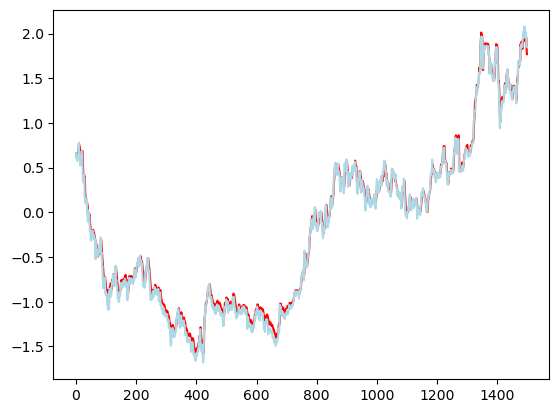

In [109]:
plt.plot(train_results['Train Predictions'][:], color= 'red')
plt.plot(train_results['Actuals'][:], color= 'lightblue')

In [110]:
test_predictions = model.predict(X_test).flatten()
ytest2=y_test.flatten()
test_results = pd.DataFrame(data={'Test Predictions': test_predictions, 'Test Actuals': ytest2})
# test_results=test_results.dropna()
test_results.head()

9/9 [==============================] - 0s 4ms/step


,Test Predictions,Test Actuals
0,1.786167,1.845422
1,1.861573,1.900100
2,1.846324,1.900100
3,1.848788,1.900100
4,1.848041,1.900100


In [111]:
compute_metrics(test_results['Test Actuals'], test_results['Test Predictions'])

{'MSE': 0.006166325776911709,
 'RMSE': 0.07852595607129982,
 'MAE': 0.05566888735814161,
 'R² Score': 0.9852873324706559,
 'Bias': 0.02529597271866133,
 'Variance': 0.005526439541128451}

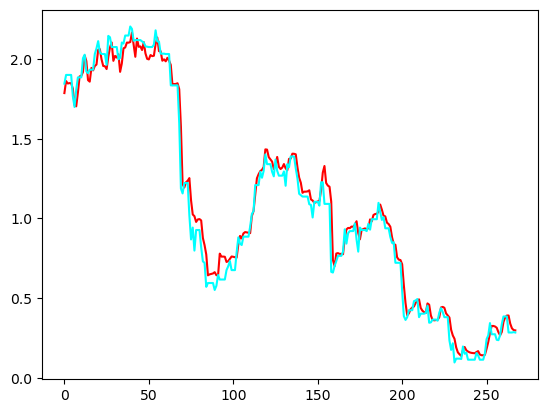

In [112]:
plt.plot(test_results['Test Predictions'][:], color='red')
plt.plot(test_results['Test Actuals'][:], color='aqua')

Now for future forecasting, we first set how many days we want to forecast then extend out dates dataframe to that many days.

We set our prediction to account for the last 45 days (in this case) to predict as many future days.

We're going to first shift the feature dataset forward for future values and predict based on those


In [113]:
future_days=45
forecast_date=pd.date_range(list(train_dates)[-1], periods=future_days, freq='1d').tolist()
dates=[]
for i in forecast_date:
    dates.append(i.date())
dates_df=pd.DataFrame({'date': np.array(dates)})
dates_df['date'] = pd.to_datetime(dates_df['date'], errors='coerce')
dates_df['date'] = dates_df['date'].dt.strftime('%Y-%m-%dT%H:%M:%S.%fZ').str[:-3]

In [114]:
df=pd.concat([df, dates_df], ignore_index=True)

In [115]:
cols_to_shift=df.columns[-7:]
df[cols_to_shift]=df[cols_to_shift].shift(future_days)

In [116]:
df=df.drop(df.index[-1])

In [117]:
df.shape

(1826, 9)

In [118]:
X_fut=df.iloc[-future_days+1:, -7:]

In [119]:
len(X_fut)

44

In [120]:
X_fut=scaler.fit_transform(X_fut)

In [121]:
len(X_fut)

44

In [122]:
X_fut.shape

(44, 7)

In [123]:
def df_to_X_y(df, window_size=5):
  X = []
  for i in range(len(df)-window_size):
    row = [[a] for a in df[i:i+window_size]]
    X.append(row)
  return np.array(X)

In [124]:
npast=10
X=df_to_X_y(X_fut, npast)

In [125]:
X.shape

(34, 10, 1, 7)

In [126]:
X=X.reshape(X.shape[0], X.shape[1], -1)

In [127]:
X.shape

(34, 10, 7)

In [128]:
predictions=model.predict(X).flatten()
prediction_results = pd.DataFrame(data = {'Predictions': predictions})

2/2 [==============================] - 0s 5ms/step


In [129]:
forecast_copy=np.repeat(prediction_results, X_fut.shape[1], axis=-1)
pred_futures=scaler.inverse_transform(forecast_copy)[:, 0]

In [130]:
len(pred_futures)

34

In [131]:
futures=pd.DataFrame(data={'date': df['date'][-X.shape[0]:], 'Predictions': pred_futures})

In [132]:
futures['date']=pd.to_datetime(futures['date'], format='ISO8601')

In [133]:
original=df[['date', 'open']]
original['open']=original['open'].shift(-future_days)
original['date']=pd.to_datetime(original['date'], format='ISO8601')
original=original.loc[original['date']>='2024-01-02']

C:\Users\Hp\AppData\Local\Temp\ipykernel_20032\2536427766.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['open']=original['open'].shift(-future_days)
C:\Users\Hp\AppData\Local\Temp\ipykernel_20032\2536427766.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['date']=pd.to_datetime(original['date'], format='ISO8601')


Text(0, 0.5, 'Open Price')

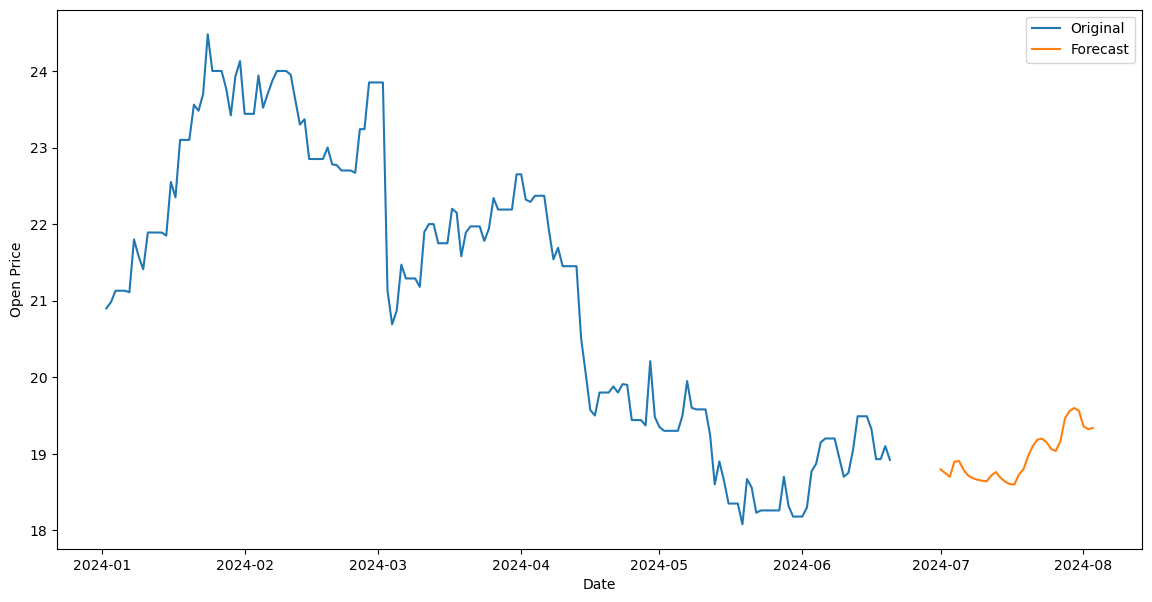

In [134]:
plt.figure(figsize=(14, 7))
sns.lineplot(x=original['date'], y=original['open'], label='Original')
sns.lineplot(x=futures['date'], y=futures['Predictions'], label='Forecast')
plt.xlabel('Date')
plt.ylabel('Open Price')